##### Copyright 2019 The TensorFlow Authors.
##### Copyright 2020 The creApple Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

This notebook shows an end-to-end example of training a TensorFlow model using Keras and Python, then export it to TensorFlow and TensorFlow Lite format. Here we will train a handwritten digit classifier using MNIST dataset.


## Enabling the Tensorflow with GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [0]:
!pip install tensorflow-gpu

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.2.0-rc3


## Setup

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# Define Constants
batch_size = 128
num_classes = 10
epochs = 100

# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

# Helper function to display specific digit images
def show_sample_digit(images, labels, digit, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  i = 0
  digit_count = 0
  while digit_count < sample_count:
    i += 1
    if (digit == labels[i]):
      plt.subplot(grid_count, grid_count, digit_count+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.gray)
      plt.xlabel(labels[i])
      digit_count += 1
  plt.show()

# Helper function to display specific digit images
def show_digit_image(image):
  # Draw digit image
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  # Major ticks every 20, minor ticks every 5
  major_ticks = np.arange(0, 29, 5)
  minor_ticks = np.arange(0, 29, 1)
  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(major_ticks)
  ax.set_yticks(minor_ticks, minor=True)
  # And a corresponding grid
  ax.grid(which='both')
  # Or if you want different settings for the grids:
  ax.grid(which='minor', alpha=0.2)
  ax.grid(which='major', alpha=0.5)
  ax.imshow(image, cmap=plt.cm.binary)

  plt.show()

# Download the digit classification model if you're using Colab,
# or print the model's local path if you're not using Colab.
def download(path):
  try:
    from google.colab import files
    files.download(path)
  except ImportError:
    import os
    print('Error download:', os.path.join(os.getcwd(), path))

## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to demonstrate how to train a image classification model and convert it to TensorFlow Lite format.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit.
![MNIST sample](https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/mnist.png)

In [0]:
# Download MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# If you can't download the MNIST dataset from Keras, please try again with an alternative method below
# path = keras.utils.get_file('mnist.npz',
#                             origin='https://s3.amazonaws.com/img-datasets/mnist.npz',
#                             file_hash='8a61469f7ea1b51cbae51d4f78837e45')
# with np.load(path, allow_pickle=True) as f:
#   train_images, train_labels = f['x_train'], f['y_train']
#   test_images, test_labels = f['x_test'], f['y_test']

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# convert class vectors to binary class matrices
#train_labels = keras.utils.to_categorical(train_labels, num_classes)
#test_labels = keras.utils.to_categorical(test_labels, num_classes)

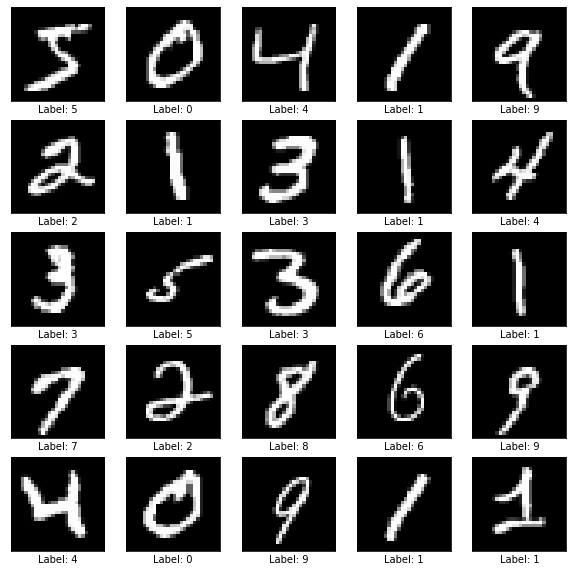

In [0]:
# Show the first 25 images in the training dataset.
show_sample(train_images, 
            ['Label: %s' % label for label in train_labels])

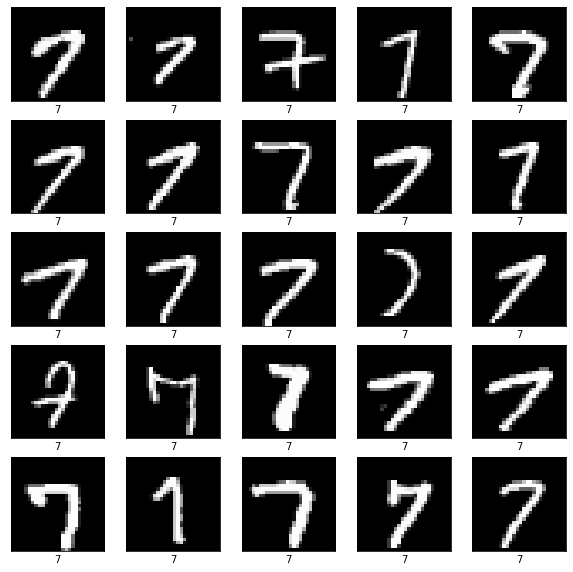

In [0]:
# Show digit 7 the first 25 images in the training dataset.
show_sample_digit(train_images, train_labels, 7)

## Train a TensorFlow model to classify digit images
We use Keras API to build a TensorFlow model that can classify the digit images. Please see this [tutorial](https://www.tensorflow.org/beta/tutorials/keras/basic_classification) if you are interested to learn more about how to build machine learning model with Keras and TensorFlow.

In [0]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),

    # keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
# Save the best model as digits_model.h5
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint('advanced_digits_model.h5', save_best_only=True)

# Define a callback to monitor val_loss
monitorEarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                       patience=5)

In [0]:
# Train the model using the early stopping callback
history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[monitorEarlyStop,modelCheckpoint])

Epoch 1/100
469/469 [==============================] - 5s 10ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0300 - val_accuracy: 0.9919
Epoch 2/100
469/469 [==============================] - 4s 10ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.0299 - val_accuracy: 0.9914
Epoch 3/100
469/469 [==============================] - 4s 10ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.0292 - val_accuracy: 0.9925
Epoch 4/100
469/469 [==============================] - 5s 10ms/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 0.0292 - val_accuracy: 0.9925
Epoch 5/100
469/469 [==============================] - 5s 10ms/step - loss: 0.0145 - accuracy: 0.9949 - val_loss: 0.0304 - val_accuracy: 0.9932
Epoch 6/100
469/469 [==============================] - 4s 10ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0317 - val_accuracy: 0.9919
Epoch 7/100
469/469 [==============================] - 4s 10ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0297 - val_accuracy:

In [0]:
# Download the digit classification model if you're using Colab, 
download('advanced_digits_model.h5')

## Evaluate our model
We run our digit classification model against our test dataset that the model hasn't seen during its training process. We want to confirm that the model didn't just remember the digits it saw but also generalize well to new images.

313/313 [==============================] - 1s 2ms/step - loss: 0.0542 - accuracy: 0.9938
Test accuracy: 0.9937999844551086


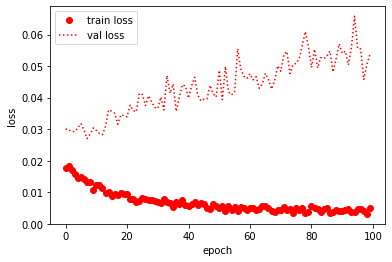

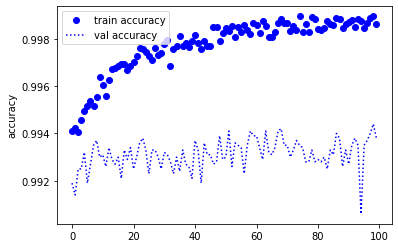

In [0]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
fig, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r:', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'bo', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'b:', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

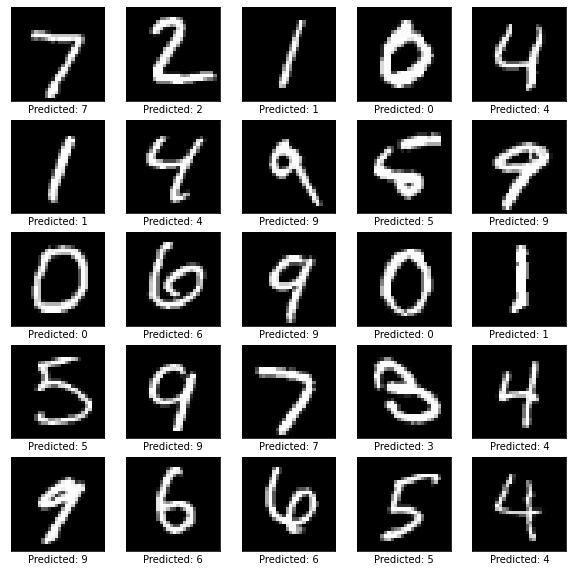

In [0]:
# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# Then plot the first 25 test images and their predicted labels.
show_sample(test_images, 
            ['Predicted: %d' % np.argmax(result) for result in predictions])

Number is  7


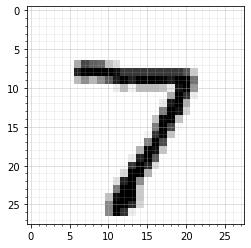

In [0]:
# Predict Model
selected_digit = 0

result = predictions[selected_digit]
result_number = np.argmax(result)
print('Number is %2i' % (result_number))

show_digit_image(test_images[selected_digit])

## Convert the Keras model to TensorFlow Lite

In [0]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model as file
f = open('mnist.tflite', "wb")
f.write(tflite_model)
f.close()

In [0]:
# Download the digit classification model if you're using Colab, 
download('mnist.tflite')

## Verify the TensorFlow Lite model

32768/28269 [==================================] - 0s 0us/step


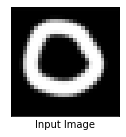

In [0]:
# Download a test image
zero_img_path = keras.utils.get_file(
    'zero.png', 
    'https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/zero.png'
)
image = keras.preprocessing.image.load_img(
    zero_img_path,
    color_mode = 'grayscale',
    target_size=(28, 28),
    interpolation='bilinear'
)

# Pre-process the image: Adding batch dimension and normalize the pixel value to [0..1]
# In training, we feed images in a batch to the model to improve training speed, making the model input shape to be (BATCH_SIZE, 28, 28).
# For inference, we still need to match the input shape with training, so we expand the input dimensions to (1, 28, 28) using np.expand_dims
input_image = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, 0)

# Show the pre-processed input image
show_sample(input_image, ['Input Image'], 1)

In [0]:
# Run inference with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_image)
interpreter.invoke()
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])()[0]

# Print the model's classification result
digit = np.argmax(output)
print('Predicted Digit: %d\nConfidence: %f' % (digit, output[digit]))

Predicted Digit: 0
Confidence: 23.972244
